In [1]:
%load_ext autoreload
%autoreload 2

### Carla tracks explorative data analysis

Main task of this notebook is to get a sense for the carla data.

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial import distance
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, LineString
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm
import networkx as nx
import numpy as np


os.chdir('../..')
os.getcwd()

from graph_creator.MapGraph import MapGraph
from graph_creator.ActorGraph import ActorGraph

In [3]:
# client = carla.Client('localhost', 2000)
# client.set_timeout(10.0)
# world = client.get_world()
# world_map = world.get_map()

### Read map graph and tracks and try to create actor graph.

In [4]:
g_map = MapGraph()
#g = give_it_a_try.create_from_carla_map(world_map)
#g.store_graph_to_file('test.pickle')
#give_it_a_try.visualize_graph()
#g.visualize_graph()
# type(g)
# g.graph.nodes

In [5]:
g_map.read_graph_from_file('/home/tmuehlen/repos/graph_coverage/carla/data/scene_0_2025-03-23_map_graph.pickle')

In [6]:
pd.DataFrame(g_map.graph.nodes(data=True))
g_map.graph.nodes(data=True)

NodeDataView({'2358_-1': {'lane_type': 'Driving', 'is_intersection': True, 'left_mark_type': 'NONE', 'right_mark_type': 'NONE', 'length': 32.625074416399, 'lane_polygon': <POLYGON ((15.162 203.391, 31.532 179.158, 31.55 175.658, 15.18 199.891, 15....>}, '27_-1': {'lane_type': 'Driving', 'is_intersection': False, 'left_mark_type': 'SolidSolid', 'right_mark_type': 'Broken', 'length': 21.419998183846474, 'lane_polygon': <POLYGON ((33.291 177.408, 33.3 155.738, 29.8 155.737, 29.791 177.407, 33.29...>}, '2343_2': {'lane_type': 'Driving', 'is_intersection': True, 'left_mark_type': 'Solid', 'right_mark_type': 'Broken', 'length': 28.749999925494194, 'lane_polygon': <POLYGON ((44.214 193.037, 15.214 192.891, 15.197 196.391, 44.196 196.537, 4...>}, '37_2': {'lane_type': 'Driving', 'is_intersection': False, 'left_mark_type': 'Solid', 'right_mark_type': 'Broken', 'length': 799.1102784052491, 'lane_polygon': <POLYGON ((15.214 192.891, 7.124 -195.233, 7.107 -191.733, 15.197 196.391, 1...>}, '2343_3'

In [7]:
pd.DataFrame(g_map.graph.edges(data=True))


,0,1,2
0,2358_-1,27_-1,{'edge_type': 'following'}
1,27_-1,2084_-1,{'edge_type': 'following'}
2,27_-1,27_-2,{'edge_type': 'neighbor'}
3,27_-1,27_1,{'edge_type': 'opposite'}
4,2343_2,37_2,{'edge_type': 'following'}
...,...,...,...
1213,1605_1,26_-2,{'edge_type': 'following'}
1214,1756_1,51_1,{'edge_type': 'following'}
1215,1756_1,1756_2,{'edge_type': 'neighbor'}
1216,1756_2,51_2,{'edge_type': 'following'}


In [8]:
tracks = pd.read_parquet('/home/tmuehlen/repos/graph_coverage/carla/data/scene_0_2025-03-23_tracks.parquet')
tracks['road_lane_id'] = tracks.road_id.astype(str) + '_' + tracks.lane_id.astype(str)
print(tracks.shape)

timestamps = tracks.timestamp.unique().tolist()
actors = tracks.actor_id.unique().tolist()
tracks.head(2).T

(12500, 24)


,0,1
actor_id,162,161
actor_type,vehicle.carlamotors.carlacola,vehicle.lincoln.mkz_2020
actor_speed_xyz,"[0.0, 0.0, -0.4899999797344208]","[0.0, 0.0, -0.4899999797344208]"
actor_acceleration_xyz,"[0.0, 0.0, -9.799999237060547]","[0.0, 0.0, -9.799999237060547]"
actor_location_xyz,"[151.52549743652344, 5.319231986999512, 0.5853...","[-217.58859252929688, 6.672847747802734, 0.285..."
actor_bbox,"[[-2.601919174194336, -1.3134948015213013, -1....","[[-2.452479839324951, -0.9183561205863953, 0.0..."
distance_till_lane_end,6.706502,15.002349
distance_from_lane_start,17.749999,39.999982
t_per_lane_id,0.0,0.093889
lane_id,-1,2


In [9]:
#tracks.actor_id.value_counts()


In [10]:
#tracks.carla_road_s.describe()


In [11]:
# ag = ActorGraph()
# #ag._create_track_lane_dict_carla(tracks)
# ag_carla = ag.from_carla_scenario(tracks, g_map, follow_vehicle_steps=1)
# ag_carla.actor_graphs[0].nodes
# ag_carla.visualize_actor_graph(5)
# #tmp = ag._create_track_lane_dict_carla(tracks)


In [12]:
ag = ActorGraph()

In [13]:
ag_carla = ag.from_carla_scenario_w_details(tracks, g_map, max_distance_m=120)


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


In [14]:
ag_carla.actor_graphs[0].nodes(data = True)

NodeDataView({162: {'lane_id': '369_-1', 's': 17.749998956918716, 'xyz': array([151.52549744,   5.31923199,   0.58530003]), 'lon_speed': 0.0}, 161: {'lane_id': '3_2', 's': 39.99998177587986, 'xyz': array([-217.58859253,    6.67284775,    0.28529999]), 'lon_speed': 0.0}, 160: {'lane_id': '5_2', 's': 0.0, 'xyz': array([-121.51011658,  -25.89393997,    0.28529999]), 'lon_speed': 0.0}, 159: {'lane_id': '50_2', 's': 0.0, 'xyz': array([-120.98020172,   27.2931385 ,    0.28530005]), 'lon_speed': -0.0}, 158: {'lane_id': '1581_-1', 's': 11.287972301244736, 'xyz': array([17.84708023, -4.49413443,  0.28529999]), 'lon_speed': 0.0}, 157: {'lane_id': '1141_-2', 's': 26.99999964237213, 'xyz': array([-62.87840652, -94.98852539,   0.28530005]), 'lon_speed': -0.0}, 156: {'lane_id': '14_1', 's': 23.750013753771782, 'xyz': array([  34.37168884, -128.51025391,    0.28530011]), 'lon_speed': 0.0}, 155: {'lane_id': '5_-2', 's': 35.99999417364597, 'xyz': array([-131.91021729,  -40.47447586,    0.28530005]), 'l

In [ ]:
#G = self.actor_graphs[timestep]
#pos = nx.spring_layout(ag_carla.actor_graphs[0], scale=1.0, k=0.1)
#node_size = 1600
#pos


In [ ]:
#ag_carla.actor_graphs[0].nodes[162]['xyz'][:2]


In [ ]:
#pos = {node: ag_carla.actor_graphs[0].nodes[node]['xyz'][:2] for node in ag_carla.actor_graphs[0].nodes}


In [17]:
#for i in range(5):
#    ag_carla.visualize_actor_graph(i,use_map_pos=True, node_size=100)

In [24]:
timestep = 3
G = ag_carla.actor_graphs[timestep]
# not sure, if G is anyhow needed? Why not always use self.actor_graphs[timestep]?
pos = {node: ag_carla.actor_graphs[timestep].nodes[node]['xyz'][:2] for node in ag_carla.actor_graphs[0].nodes}
node_size = 400


In [25]:
# Why remove lonely actors?
labels = {node: node for node in ag_carla.actor_graphs[timestep].nodes() if G.degree(node) > 0}
nodes_with_edges = [node for node in G.nodes() if G.degree(node) > 0]


/tmp/ipykernel_15826/2454776932.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


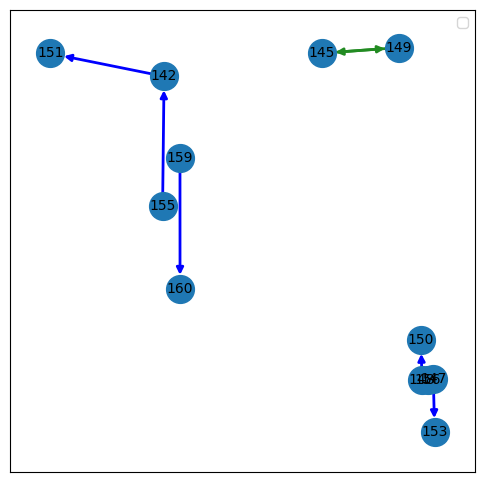

In [ ]:
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(G, pos, nodelist=nodes_with_edges, node_size=node_size)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')


# Draw edges with different styles based on edge type
edge_type_following_lead = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'following_lead']
#edge_type_leading_vehicle = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'leading_vehicle']
edge_type_direct_neighbor_vehicle = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'direct_neighbor_vehicle']
edge_type_neighbor_vehicle = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'neighbor_vehicle']
edge_type_opposite_vehicle = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'opposite_vehicle']


nx.draw_networkx_edges(G, pos, edgelist=edge_type_following_lead, width=2, edge_color='blue', arrows=True, node_size=node_size, label='following_lead')
#nx.draw_networkx_edges(G, pos, edgelist=edge_type_leading_vehicle, width=2, edge_color='cyan', label='leading_vehicle')
nx.draw_networkx_edges(G, pos, edgelist=edge_type_direct_neighbor_vehicle, width=2, edge_color='springgreen', arrows=True,  node_size=node_size,label='direct_neighbor_vehicle')
nx.draw_networkx_edges(G, pos, edgelist=edge_type_neighbor_vehicle, width=2, edge_color='forestgreen', arrows=True, node_size=node_size, label='neighbor_vehicle')
nx.draw_networkx_edges(G, pos, edgelist=edge_type_opposite_vehicle, width=2, edge_color='orange', arrows=True, node_size=node_size, label='opposite_vehicle')

#plt.legend()
plt.show()

In [30]:
edge_type_neighbor_vehicle

[(156, 147), (156, 147), (149, 145), (147, 156), (147, 156), (145, 149)]

In [ ]:
#tracks.actor_id.value_counts()


In [ ]:
ag = ActorGraph()

In [ ]:
track_lane_dict, track_s_value_dict, track_xyz_pos_dict, track_speed_lon_dict = ag._create_track_lane_dict_carla_w_details(tracks)
# !!! continue from here!
# Next steps: add opposite direction
# try to add positions to plots.

In [ ]:
track_lane_dict
track_s_value_dict
timestamps = tracks.timestamp.unique().tolist()
actors = tracks.actor_id.unique().tolist()

In [ ]:
# timestamps
# actors
tracks.head(1).T

In [ ]:
t = 5
t_value = timestamps[t]

#follow_vehicle_steps = 2 # needed?
G_map = g_map
max_distance_lead_veh_m = 70

max_distance_neighbor_forward_m = 30

In [ ]:
G_t = nx.MultiDiGraph()

In [ ]:
for track_id, lane_ids in track_lane_dict.items():
    if lane_ids[t] is not None:
        G_t.add_node(track_id, lane_id=lane_ids[t], s = track_s_value_dict[track_id][t])
        # Do we need to add for information about the track here? 


In [ ]:
G_t.nodes(data=True)

In [ ]:
# track_id_A = 151
# track_id_B = 152

# print(G_t.nodes[track_id_A], G_t.nodes[track_id_B])


In [ ]:
# print(track_lane_dict[track_id_A][t])
# print(track_lane_dict[track_id_B][t])


In [ ]:
#nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_A[t], weight=None)


In [ ]:
# track_id_A, lane_ids_A = list(track_lane_dict.items())[0]
# print(track_id_A, lane_ids_A)
# track_id_B, lane_ids_B = list(track_lane_dict.items())[11]
# print(track_id_B, lane_ids_B)

# # Check for "following_lead" and "leading_vehicle"
# print(nx.has_path(G_map.graph, lane_ids_A[t], lane_ids_B[t]))

# path = nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_B[t], weight=None)
# print(len(path), path)
# print(all(G_map.graph[u][v][0]['edge_type'] == 'following' for u, v in zip(path[:-1], path[1:])))


In [ ]:
#lane_ids_A = track_lane_dict[track_id_A]
#lane_ids_B = track_lane_dict[track_id_B]


In [ ]:
# nx.has_path(g_map.graph, lane_ids_A[t], lane_ids_B[t])

# path = nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_B[t], weight=None)
# path

In [ ]:
# len(path)
# all(G_map.graph[u][v][0]['edge_type'] == 'following' for u, v in zip(path[:-1], path[1:]))

In [ ]:
# G_map.graph.nodes[path[0]]

In [ ]:
# path_length = sum([G_map.graph.nodes[node]['length'] for node in path[:-1]]) + track_s_value_dict[track_id_B][t] - track_s_value_dict[track_id_A][t]
# path_length

# [G_map.graph.nodes[node]['length'] for node in path[:-1]]

In [ ]:
# first case: both on same lane:
# my suspecion is, that here there are singular loops created. 
#print(len(path) == 1)


for track_id_A, lane_ids_A in track_lane_dict.items():

    if lane_ids_A[t] is None:
        continue

    for track_id_B, lane_ids_B in track_lane_dict.items():
        if track_id_A == track_id_B or lane_ids_B[t] is None:
            continue

        # Check for "following_lead" and "leading_vehicle"
        if nx.has_path(g_map.graph, lane_ids_A[t], lane_ids_B[t]):

            path = nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_B[t], weight=None)

            if len(path) == 1: # i.e. both on same lane
                if (track_s_value_dict[track_id_B][t] > track_s_value_dict[track_id_A][t]) and ((track_s_value_dict[track_id_B][t] - track_s_value_dict[track_id_A][t]) < max_distance_lead_veh_m):
                    # isn't this the wrong way around?
                    G_t.add_edge(track_id_B, track_id_A, edge_type='leading_vehicle', path_length = track_s_value_dict[track_id_B][t] - track_s_value_dict[track_id_A][t])
                    G_t.add_edge(track_id_A, track_id_B, edge_type='following_lead', path_length = track_s_value_dict[track_id_B][t] - track_s_value_dict[track_id_A][t])
                    print('added')

            # second case: both on different, but following lanes:
            if len(path) > 1 and all(G_map.graph[u][v][0]['edge_type'] == 'following' for u, v in zip(path[:-1], path[1:])):
                path_length = sum([G_map.graph.nodes[node]['length'] for node in path[:-1]]) + track_s_value_dict[track_id_B][t] - track_s_value_dict[track_id_A][t]
                #print(path_length)
                if (path_length < max_distance_lead_veh_m) :
                    G_t.add_edge(track_id_B, track_id_A, edge_type='leading_vehicle', path_length = path_length)
                    G_t.add_edge(track_id_A, track_id_B, edge_type='following_lead', path_length = path_length)
                    print('added')

            # third case: on neighboring lanes, forward
            if (sum([G_map.graph[u][v][0]['edge_type']  == 'neighbor' for u, v in zip(path[:-1], path[1:])]) == 1) and (sum([G_map.graph[u][v][0]['edge_type']  == 'following' for u, v in zip(path[:-1], path[1:])] )  == len(path) - 2):
                # remove the neighbor node, otherwise that stretch is counted twice.
                path_length = sum([G_map.graph.nodes[path[i]]['length'] for i in range(len(path) - 1) if G_map.graph[path[i]][path[i + 1]][0]['edge_type'] != 'neighbor']) + track_s_value_dict[track_id_B][t] - track_s_value_dict[track_id_A][t]
                if path_length < 40:
                    G_t.add_edge(track_id_B, track_id_A, edge_type='neighbor_vehicle', path_length = path_length)
                    G_t.add_edge(track_id_A, track_id_B, edge_type='neighbor_vehicle', path_length = path_length)
                    print('added')



In [ ]:
path = ['1697_-1', '39_1', '39_2', '831_1', '31_2', '30_2', '2165_1']

[G_map.graph.nodes[path[i]]['length'] for i in range(len(path) - 1) if G_map.graph[path[i]][path[i + 1]][0]['edge_type'] != 'neighbor']

In [ ]:
#[G_map.graph.nodes[path[i]]['length'] for i in range(len(path) - 1) if G_map.graph[path[i]][path[i + 1]]]
G_map.graph[path[1]][path[2]][0]['edge']


In [ ]:
[G_map.graph[u][v][0]['edge_type'] for u, v in zip(path[:-1], path[1:])]

In [ ]:
### continue from here, needs some debugging...
# there needs to be exactly one neighbor and all other edges following
if (sum([G_map.graph[u][v][0]['edge_type']  == 'neighbor' for u, v in zip(path[:-1], path[1:])]) == 1) and (sum([G_map.graph[u][v][0]['edge_type']  == 'following' for u, v in zip(path[:-1], path[1:])] )  == len(path) - 2)


In [ ]:
pd.DataFrame(G_t.edges(data=True))
G_t.edges(data=True)


In [ ]:
G_t.edges(data = True)

In [ ]:
G_t[161][142]

In [ ]:


print(lane_ids_A[t], lane_ids_B[t])
print(lane_ids_A[t], lane_ids_B[t])

nx.has_path(g_map.graph, lane_ids_A[t], lane_ids_B[t])

In [ ]:
path = nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_B[t], weight=None)
path

In [ ]:
print(G_t.nodes[track_id_A])
print(G_t.nodes[track_id_B])


In [ ]:
print(G_t.nodes[94])
print(G_t.nodes[84])


In [ ]:
np.sqrt((44 + 26)**2 + (69-52)**2)


In [ ]:
path = nx.shortest_path(G_map.graph, '12_1', '6_1', weight=None)
path

In [ ]:
all(G_map.graph[u][v][0]['edge_type'] == 'following' for u, v in zip(path[:-1], path[1:]))

In [ ]:
tracks[tracks.timestamp == t_value]


In [ ]:
nx.draw(G_t, with_labels=True)

In [ ]:

# Add edges based on the conditions
for track_id_A, lane_ids_A in track_lane_dict.items():

    if lane_ids_A[t] is None:
        continue
    for track_id_B, lane_ids_B in track_lane_dict.items():
        if track_id_A == track_id_B or lane_ids_B[t] is None:
            continue

        # Check for "following_lead" and "leading_vehicle"
        if nx.has_path(g_map.graph, lane_ids_A[t], lane_ids_B[t]):
            path = nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_B[t], weight=None)
            if len(path) - 1 <= self.follow_vehicle_steps and all(G_map.graph[u][v][0]['edge_type'] == 'following' for u, v in zip(path[:-1], path[1:])):
                G_t.add_edge(track_id_B, track_id_A, edge_type='leading_vehicle')
                G_t.add_edge(track_id_A, track_id_B, edge_type='following_lead')
                #if (t==20 and track_id_A == '73020' and track_id_B == 'AV'):
                #    print("wrong")

        # Check for "direct_neighbor_vehicle"
        if G_map.graph.has_edge(lane_ids_A[t], lane_ids_B[t]) and G_map.graph[lane_ids_A[t]][lane_ids_B[t]][0]['edge_type'] == 'neighbor':
            G_t.add_edge(track_id_A, track_id_B, edge_type='direct_neighbor_vehicle')

        # Check for "neighbor_vehicle"
        if nx.has_path(G_map.graph, lane_ids_A[t], lane_ids_B[t]):
            path = nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_B[t], weight=None)
            if len(path) - 1 <= self.follow_vehicle_steps and any(G_map.graph[u][v][0]['edge_type'] == 'neighbor' for u, v in zip(path[:-1], path[1:])) and not G_t.has_edge(track_id_A, track_id_B):
                G_t.add_edge(track_id_A, track_id_B, edge_type='neighbor_vehicle')
                G_t.add_edge(track_id_B, track_id_A, edge_type='neighbor_vehicle') # works in both direction - maybe another type here? 

        # Check for "opposite_vehicle"
        for u, v, data in G_map.graph.edges(data=True):
            if data['edge_type'] == 'opposite':
                if nx.has_path(G_map.graph, lane_ids_A[t], u) and nx.has_path(G_map.graph, lane_ids_B[t], v):
                    path_A = nx.shortest_path(G_map.graph, lane_ids_A[t], u, weight=None)
                    path_B = nx.shortest_path(G_map.graph, lane_ids_B[t], v, weight=None)
                    # This ensures that the both paths combined are limited in length. 
                    # Next, we are only looking for vehicle on a direct opposite lane, so no neighbors are allowed. If we allow neighbors, we have to careful to ignore double neighbors, that lead to the same lane again. 
                    if (len(path_A) - 1 + len(path_B) - 1 <= self.follow_vehicle_steps and
                        all(G_map.graph[u][v][0]['edge_type'] != 'neighbor' for u, v in zip(path_A[:-1], path_A[1:])) and
                        all(G_map.graph[u][v][0]['edge_type'] != 'neighbor' for u, v in zip(path_B[:-1], path_B[1:])) and
                        sum(1 for u, v in zip(path_A[:-1], path_A[1:]) if G_map.graph[u][v][0]['edge_type'] == 'opposite') == 1 and
                        sum(1 for u, v in zip(path_B[:-1], path_B[1:]) if G_map.graph[u][v][0]['edge_type'] == 'opposite') == 1):
                        G_t.add_edge(track_id_A, track_id_B, edge_type='opposite_vehicle')
                        G_t.add_edge(track_id_B, track_id_A, edge_type='opposite_vehicle')


In [ ]:
# just to make sure...
tracks.sort_values(['actor_id', 'timestamp'], inplace=True)


In [ ]:

track_lane_dict = {}

#actor = actors[0]
for actor in actors:
    mask = tracks.actor_id == actor
    track_lane_dict[actor] = tracks[mask].road_lane_id






In [ ]:
timestep_graphs = []

#for t in timestamps:
t = timestamps[0]
G_t = nx.MultiDiGraph()



In [ ]:
#track = actors[0]
#mask = (tracks.actor_id == track) & (tracks.timestamp == t)
# mask.sum()
#str(tracks[mask].road_id.iloc[0]) + '_' + str(tracks[mask].lane_id.iloc[0])

In [ ]:
for track in actors:
    mask = (tracks.actor_id == track) & (tracks.timestamp == t)
    G_t.add_node(track, lane_id = str(tracks[mask].road_id.iloc[0]) + '_' + str(tracks[mask].lane_id.iloc[0]))



In [ ]:
G_t.nodes
track_a = actors[0]
track_b = actors[1]
mask_a = (tracks.actor_id == track_a) & (tracks.timestamp == t)
mask_b = (tracks.actor_id == track_b) & (tracks.timestamp == t)


tracks[mask_a].road_lane_id.iloc[0]
tracks[mask_b].road_lane_id.iloc[0]


In [ ]:
for i_a in range(len(actors) - 1):
    for i_b in range(i_a + 1, len(actors)):
        mask_a = (tracks.actor_id == actors[i_a]) & (tracks.timestamp == t)
        mask_b = (tracks.actor_id == actors[i_b]) & (tracks.timestamp == t)

        if nx.shortest_path_length(g_map.graph, tracks[mask_a].road_lane_id.iloc[0], tracks[mask_b].road_lane_id.iloc[0]) < 3:
            G_t.add_edge(actors[i_a], actors[i_b], edge_type = 'leading_vehicle')
            G_t.add_edge(actors[i_b], actors[i_a], edge_type = 'following_vehicle')


In [ ]:
i_a = 3
i_b = 4
mask_a = (tracks.actor_id == actors[i_a]) & (tracks.timestamp == t)
mask_b = (tracks.actor_id == actors[i_b]) & (tracks.timestamp == t)

path = nx.shortest_path(g_map.graph, tracks[mask_a].road_lane_id.iloc[0], tracks[mask_b].road_lane_id.iloc[0])
path

In [ ]:
tmp = [g_map.graph[path[i]][path[i + 1]] for i in range(len(path) -1)]
tmp

In [ ]:
# need to get the lane segment length, if possible
pd.DataFrame(g_map.graph.nodes(data = True))[1].iloc[0]


In [ ]:
nx.draw(G_t)


In [ ]:

#    def create_argoverse_actor_graphs(self, G_map):



    # Add edges based on the conditions
    for track_id_A, lane_ids_A in self.track_lane_dict.items():
        if lane_ids_A[t] is None:
            continue
        for track_id_B, lane_ids_B in self.track_lane_dict.items():
            if track_id_A == track_id_B or lane_ids_B[t] is None:
                continue

            # Check for "following_lead" and "leading_vehicle"
            if nx.has_path(G_map.graph, lane_ids_A[t], lane_ids_B[t]):
                path = nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_B[t], weight=None)
                if len(path) - 1 <= self.follow_vehicle_steps and all(G_map.graph[u][v][0]['edge_type'] == 'following' for u, v in zip(path[:-1], path[1:])):
                    G_t.add_edge(track_id_B, track_id_A, edge_type='leading_vehicle')
                    G_t.add_edge(track_id_A, track_id_B, edge_type='following_lead')
                    #if (t==20 and track_id_A == '73020' and track_id_B == 'AV'):
                    #    print("wrong")

            # Check for "direct_neighbor_vehicle"
            if G_map.graph.has_edge(lane_ids_A[t], lane_ids_B[t]) and G_map.graph[lane_ids_A[t]][lane_ids_B[t]][0]['edge_type'] == 'neighbor':
                G_t.add_edge(track_id_A, track_id_B, edge_type='direct_neighbor_vehicle')

            # Check for "neighbor_vehicle"
            if nx.has_path(G_map.graph, lane_ids_A[t], lane_ids_B[t]):
                path = nx.shortest_path(G_map.graph, lane_ids_A[t], lane_ids_B[t], weight=None)
                if len(path) - 1 <= self.follow_vehicle_steps and any(G_map.graph[u][v][0]['edge_type'] == 'neighbor' for u, v in zip(path[:-1], path[1:])) and not G_t.has_edge(track_id_A, track_id_B):
                    G_t.add_edge(track_id_A, track_id_B, edge_type='neighbor_vehicle')
                    G_t.add_edge(track_id_B, track_id_A, edge_type='neighbor_vehicle') # works in both direction - maybe another type here? 

            # Check for "opposite_vehicle"
            for u, v, data in G_map.graph.edges(data=True):
                if data['edge_type'] == 'opposite':
                    if nx.has_path(G_map.graph, lane_ids_A[t], u) and nx.has_path(G_map.graph, lane_ids_B[t], v):
                        path_A = nx.shortest_path(G_map.graph, lane_ids_A[t], u, weight=None)
                        path_B = nx.shortest_path(G_map.graph, lane_ids_B[t], v, weight=None)
                        # This ensures that the both paths combined are limited in length. 
                        # Next, we are only looking for vehicle on a direct opposite lane, so no neighbors are allowed. If we allow neighbors, we have to careful to ignore double neighbors, that lead to the same lane again. 
                        if (len(path_A) - 1 + len(path_B) - 1 <= self.follow_vehicle_steps and
                            all(G_map.graph[u][v][0]['edge_type'] != 'neighbor' for u, v in zip(path_A[:-1], path_A[1:])) and
                            all(G_map.graph[u][v][0]['edge_type'] != 'neighbor' for u, v in zip(path_B[:-1], path_B[1:])) and
                            sum(1 for u, v in zip(path_A[:-1], path_A[1:]) if G_map.graph[u][v][0]['edge_type'] == 'opposite') == 1 and
                            sum(1 for u, v in zip(path_B[:-1], path_B[1:]) if G_map.graph[u][v][0]['edge_type'] == 'opposite') == 1):
                            G_t.add_edge(track_id_A, track_id_B, edge_type='opposite_vehicle')
                            G_t.add_edge(track_id_B, track_id_A, edge_type='opposite_vehicle')

    timestep_graphs.append(G_t)

return timestep_graphs


# Notebook junkyard

In [ ]:
os.getcwd()



In [ ]:
track_files = os.listdir(Path('carla/data') )
dfs = []
for file in track_files:
    df = pd.read_parquet(Path('carla/data') / file)
    df['file_name'] = file
    dfs.append(df)

tracks_df = pd.concat(dfs)

tracks_df['actor_location_x'] = tracks_df.actor_location_xyz.apply(lambda x: x[0])
tracks_df['actor_location_y'] = tracks_df.actor_location_xyz.apply(lambda x: x[1])
tracks_df['actor_location_z'] = tracks_df.actor_location_xyz.apply(lambda x: x[2])

print(tracks_df.shape)
tracks_df.head(2)


In [ ]:
sns.histplot(data = tracks_df, x = 'actor_speed', bins=100, hue = 'file_name')
plt.show()
sns.histplot(data = tracks_df, x = 'actor_acceleration', bins=100, hue = 'file_name')
plt.show()
tracks_df.groupby(['map', 'file_name']).size()


### High level learnings:

* hm, timestamps are not alligned, getting syncronous mode running would be great...
* road_id and lane_id seem to be ok


In [ ]:
# tracks_df.timestamp.value_counts()
# tracks_df.road_id.value_counts()
# tracks_df.actor_id.value_counts()

In [ ]:
# pick a timestamp and filename and calculate distances:

In [ ]:
i = 100

mask = (tracks_df.timestamp == tracks_df.timestamp.iloc[i]) &  (tracks_df.file_name == tracks_df.file_name.iloc[i])
mask.sum()
actor_id = tracks_df.actor_id.iloc[i]

plt.scatter(tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_y, label = 'OMV')
plt.scatter(tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_y, label = 'ego')
plt.show()
tracks_df[mask][['actor_location_x', 'actor_location_y']]

In [ ]:
# define 1 actor as the ego:
# distance.pdist(tracks_df[mask][['actor_location_x', 'actor_location_y']])
# tracks_df[mask][['actor_location_x', 'actor_location_y']]

In [ ]:
# dist_threshold = 150
# distance.cdist(tracks_df[mask & (tracks_df.actor_id == actor_id)][['actor_location_x', 'actor_location_y']], tracks_df[mask][['actor_location_x', 'actor_location_y']])


In [ ]:
#tracks_df.actor_id

#tracks_df[mask & (tracks_df.actor_id == actor_id) ][['actor_location_x', 'actor_location_y']]

In [ ]:
# print(actor_id)
#tracks_df[mask]


In [ ]:
#tracks_df[mask]['map'].iloc[0]

#client.load_world('/Game/' + tracks_df[mask]['map'].iloc[0])
#world_map = world.get_map()
#xodr_map = world_map.to_opendrive()

#with open("carla_map.xodr", "w") as file:
#    file.write(xodr_map)

### map data preparation

In [ ]:

#ET.fromstring('carla_map.xodr')
tree = ET.parse('carla_map.xodr')
root = tree.getroot()


In [ ]:
#type(tmp)
#print(tmp)

# Load the OpenDRIVE XML
#tree = ET.ElementTree(ET.fromstring('carla_map.xodr'))

# OpenDRIVE namespace
#namespace = {'xodr': 'http://www.opendrive.org'}

# Find all roads
#roads = root.findall("road")
#print(f"Total Roads Found: {len(roads)}")


In [ ]:
junctions = root.findall('junction')
print(len(junctions))

roads = root.findall('road')
print(len(roads))
#i = 10
#roads[i].get('id')
#print(roads[i].get('length'), roads[i].get('junction')) # no junction is -1


In [ ]:
# roads[i].find('link').find('successor').get('elementId')
# roads[i].find('link').find('predecessor').get('elementId')

In [ ]:
all_lanes = []
# all_lanes is a list, containing all individual lanes, with their right/left neighbor (max 1), their type, 
# length, width, and predecessor and successor


In [ ]:
# start buiding the lane map:
# non-junctions:
#tracks_df[mask]
road = roads[0]
road.get('id')
lanes = road.find('lanes')
left_lanes = lanes.find('laneSection').find('left')
right_lanes = lanes.find('laneSection').find('right')
links = road.find('link')
predecessor = links.find('predecessor')
successor = links.find('successor')

In [ ]:
left_lanes[0].get('id')
lane = left_lanes[0]
lane.get('type')
float(road.get('length'))
left_lanes

In [ ]:
road.get('junction')


In [ ]:
# https://carla.org/Doxygen/html/df/d85/classcarla_1_1road_1_1Lane.html#a0a674e01dcb347b12407a26b94521685

In [ ]:
# process left lanes of road's:
left_lane_ids = [int(lane.get('id')) for lane in left_lanes]
print(left_lane_ids)
# left neighbors for right lanes
left_neighbor = left_lane_ids[1:]
left_neighbor = left_neighbor + [-1] # todo, need to check, if this lane actually exists.
print(left_neighbor)
# right neighbors for right lanes:
right_neighbor = left_lane_ids[:-1]
right_neighbor = [None] + right_neighbor
print(right_neighbor)

In [ ]:
i = 1
#for i in range(len(left_lanes)):
lane_dict = {} 
lane_dict['lane_road_id'] = road.get('id') + '_' + left_lanes[i].get('id')
lane_dict['type'] = left_lanes[i].get('type')
lane_dict['length'] = float(road.get('length'))
if left_neighbor[i]:
    lane_dict['left_neighbor'] = road.get('id') + '_' + str(left_neighbor[i])

if right_neighbor[i]:
    lane_dict['right_neighbor'] = road.get('id') + '_' + str(right_neighbor[i])

lane_dict['lane_direction'] = 'left'
#all_lanes.append(lane_dict)

lane_dict['lane_id'] = left_lanes[i].get('id')
lane_dict['road_id'] = road.get('id')

road.get('junction')

In [ ]:
left_lanes[i]

In [ ]:
lane_dict

In [ ]:
if road.get('junction') == '-1':
    if predecessor.get('elementType') == 'junction':
        print('test')


In [ ]:
predecessor.get('elementId')

In [ ]:
# get the predecessor junction:
pred_junction = [j for j in junctions if j.get('id') == predecessor.get('elementId')][0]
all_pred_connections = pred_junction.findall('connection')
all_pred_connections
#pred_junction.get('id')

In [ ]:
connections = [conn for conn in all_pred_connections if conn.get('incomingRoad') == road.get('id')]
connections

In [ ]:

#for i in range(4):
i = 0
lane_links = connections[i].findall('laneLink')
print(len(lane_links))
print(connections[i].get('incomingRoad'), connections[i].get('connectingRoad'), lane_links[0].get('from'), lane_links[0].get('to'))

#print(connections[0].get('incomingRoad'), connections[0].get('connectingRoad'), lane_links[0].get('from'), lane_links[0].get('to'))
#print(connections[0].get('incomingRoad'), connections[0].get('connectingRoad'), lane_links[0].get('from'), lane_links[0].get('to'))
#print(connections[0].get('incomingRoad'), connections[0].get('connectingRoad'), lane_links[0].get('from'), lane_links[0].get('to'))


In [ ]:
predecessor_list = []
for lane_link in lane_links:
    if (lane_link.get('to') == lane_dict['lane_id']) & (connections[i].get('incomingRoad') == lane_dict['road_id']):
        print(lane_dict['lane_id'], 
              lane_dict['road_id'], 
              lane_link.get('to'), 
              lane_link.get('from'),
              connections[i].get('incomingRoad'), 
              connections[i].get('connectingRoad'))
        predecessor_list.append()


In [ ]:
lane_dict

In [ ]:
lane_links[0].get('to')

In [ ]:
lane_dict

In [ ]:
#

In [ ]:
all_lanes
lane_dict

In [ ]:
# process right lanes of roads:

In [ ]:
right_lane_ids = [int(lane.get('id')) for lane in right_lanes]
print(right_lane_ids)
# left neighbors for right lanes
left_neighbor = right_lane_ids[:-1]
left_neighbor = [1] + left_neighbor # todo: check if this actually exists
print(left_neighbor)
# right neighbors for right lanes:
right_neighbor = right_lane_ids[1:]
right_neighbor = right_neighbor + [None]
print(right_neighbor)


In [ ]:
for i in range(len(right_lanes)):
    lane_dict = {} 
    lane_dict['lane_id'] = road.get('id') + '_' + right_lanes[i].get('id')
    lane_dict['type'] = right_lanes[i].get('type')
    lane_dict['length'] = float(road.get('length'))
    if left_neighbor[i]:
        lane_dict['left_neighbor'] = road.get('id') + '_' + str(left_neighbor[i])

    if right_neighbor[i]:
        lane_dict['right_neighbor'] = road.get('id') + '_' + str(right_neighbor[i])
    lane_dict['lane_direction'] = 'right'
    all_lanes.append(lane_dict)


In [ ]:
all_lanes

### Continue from here

* Fill up the lane dict with left/right neighbor
* Fill up lane dict with predessecor/successor
    * split by if next road is a junction or not.
* Fill it into Marius' road network class

In [ ]:
print(ET.tostring(roads[i], encoding = 'utf-8').decode('utf-8'))


In [ ]:
# Extract road connections
road_connections = {}

for road in roads:
    road_id = road.get("id")
    
    link = road.find("link")
    if link is not None:
        successor = link.find("successor")
        predecessor = link.find("predecessor")

        successor_id = successor.get("elementId") if successor is not None else None
        predecessor_id = predecessor.get("elementId") if predecessor is not None else None

        road_connections[road_id] = {
            "successor": successor_id,
            "predecessor": predecessor_id
        }

# Print road connections
for road_id, links in road_connections.items():
    print(f"Road ID: {road_id} -> Successor: {links['successor']}, Predecessor: {links['predecessor']}")


In [ ]:
carla_map = world.get_map()
waypoints = carla_map.generate_waypoints(0.50)

# Store road polygons
road_polygons = []

# Process each waypoint to extract boundaries
for waypoint in waypoints:
    # Get left and right lane markings
    left_marking = waypoint.get_left_lane()
    right_marking = waypoint.get_right_lane()

    if left_marking and right_marking:
        # Extract boundary points
        left_x, left_y = left_marking.transform.location.x, left_marking.transform.location.y
        right_x, right_y = right_marking.transform.location.x, right_marking.transform.location.y

        # Create polygon for road segment
        road_polygon = Polygon([
            (waypoint.transform.location.x, waypoint.transform.location.y),  # Center
            (left_x, left_y),  # Left boundary
            (right_x, right_y)  # Right boundary
        ])

        road_polygons.append(road_polygon)

print(f"Total road polygons created: {len(road_polygons)}")

In [ ]:
# Plot the road polygons
plt.figure(figsize=(10, 8))

for polygon in road_polygons:
    x, y = polygon.exterior.xy  # Get polygon boundary
    plt.fill(x, y, alpha=0.5, edgecolor="black")

plt.scatter(tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_y, label = 'OMV')
plt.scatter(tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_y, label = 'ego')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("CARLA Road Boundaries with Shapely Polygons")
plt.grid(True)
plt.show()

### Finally, start building the graph

In [ ]:
tracks_df.file_name.unique()

In [ ]:

file_name = tracks_df.file_name.unique()[3]
mask_file_name = tracks_df.file_name == file_name
mask_time = ((tracks_df.timestamp - tracks_df[mask_file_name].timestamp.mean()).abs() <= 3) # i.e. 10 seconds

tracks_subset = tracks_df[mask_file_name & mask_time]

actors = tracks_subset.actor_id.unique().tolist()
ego_idx = 0
ls_list = []
for actor in actors:
    mask_actor = (tracks_subset.actor_id == actor)
    ls_list.append(LineString(tracks_subset[mask_actor][['actor_location_x', 'actor_location_y']].values.tolist()))

#mask_actor = (tracks_subset.actor_id == actors[1])
#ls1 = LineString(tracks_subset[mask_actor][['actor_location_x', 'actor_location_y']].values.tolist())

#[ls.crosses(ls_list[ego_idx]) for ls in ls_list]


In [ ]:
# include all actors with a crossing path and inside a circle:

In [ ]:
[ls.distance(ls_list[ego_idx]) for ls in ls_list]

In [ ]:
[ls.distance(ls_list[ego_idx]) < 80 for ls in ls_list]
actor_idx = [i for i in range(len(ls_list)) if ls_list[i].distance(ls_list[ego_idx]) < 80 ]


In [ ]:
actors_in_graph = [actors[i] for i in actor_idx]


In [ ]:
timestamp = tracks_subset.timestamp.unique()[60]

In [ ]:
# First very simple rule: distance between actors < 40 m

mask = tracks_subset.actor_id.isin(actors_in_graph) & (tracks_subset.timestamp == timestamp)
tracks_subset[mask]